## Extraction train image & label from isprs20 data

In [220]:
## environmental setting
import numpy as np
import cv2
import geopandas as gpd
import os, glob
import matplotlib.pyplot as plt
import PIL
from PIL import ImageFont, ImageDraw, Image

In [221]:
dir = "C:/Users/user/Desktop/easyOCR_LL/isprs20_data/zone1/"
folder_list = os.listdir(dir)
folder_list.sort()

isprs20 = []

for i in folder_list:
    file_list = dir + i + '/*.png'
    file_list = glob.glob(file_list)
    
    for j in file_list:
        split_list = j.split('-')
        zone = split_list[0][-2:]
        location = split_list[1]
        date = split_list[2] + '-' + split_list[3]
        image = cv2.imread(j)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # bbox from geometry data
        gdf = gpd.GeoDataFrame.from_file(j[:-3] + 'shp')
        
        bbox = []
        for n in range(0, len(gdf.geometry)):
            try:
                x, y = gdf.geometry[n].exterior.coords.xy
            except:
                print('멀티폴리곤 제외')
                continue
            
            for k in range(0, len(y)):
                y[k] *= -1
            xy = xy = [(x[h], y[h]) for h in range(0, len(x))]
            
            bbox.append(xy)
        
        # label
        target = gdf.iloc[:, 0].tolist()
        
        temp = {'zone':zone, 'location':location, 'date':date, 
                'image':image, 'bbox':bbox, 'target':target}
        isprs20.append(temp)

멀티폴리곤 제외
멀티폴리곤 제외


In [222]:
dir = "C:/Users/user/Desktop/easyOCR_LL/isprs20_data/zone2/"
folder_list = os.listdir(dir)
folder_list.sort()

for i in folder_list:
    file_list = dir + i + '/*.png'
    file_list = glob.glob(file_list)
    
    for j in file_list:
        split_list = j.split('-')
        zone = split_list[0][-2:]
        location = split_list[1]
        date = split_list[2] + '-' + split_list[3]
        image = cv2.imread(j)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # bbox from geometry data
        gdf = gpd.GeoDataFrame.from_file(j[:-3] + 'shp')
        
        bbox = []
        for n in range(0, len(gdf.geometry)):
            try:
                x, y = gdf.geometry[n].exterior.coords.xy
            except:
                print('멀티폴리곤 제외')
                continue
            
            for k in range(0, len(y)):
                y[k] *= -1
            xy = xy = [(x[h], y[h]) for h in range(0, len(x))]
            
            bbox.append(xy)
        
        # label
        target = gdf.iloc[:, 0].tolist()
        
        temp = {'zone':zone, 'location':location, 'date':date, 
                'image':image, 'bbox':bbox, 'target':target}
        isprs20.append(temp)

In [223]:
len(isprs20)

1664

In [224]:
## Visualize BBox

def create_bbox(img, bbox):
  temp_pil = Image.fromarray(img)
  draw = ImageDraw.Draw(temp_pil, "RGBA")

  for coords in bbox:
    draw.polygon(coords, fill=(0, 255, 0 ,80), outline = (0, 255, 0))

  plt.figure(figsize=(10, 10))
  plt.imshow(temp_pil)
  plt.show()

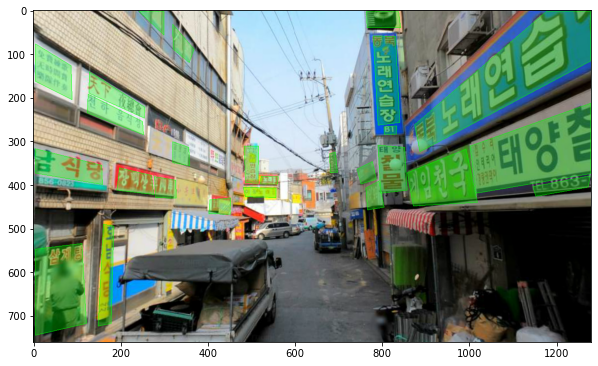

In [225]:
create_bbox(isprs20[1]['image'], isprs20[1]['bbox'])

In [226]:
for file in isprs20:
    for idx in range(0, len(file['bbox'])):
        try:
            mask = Image.new('1', (file['image'].shape[1], file['image'].shape[0]),0)
            ImageDraw.Draw(mask).polygon(file['bbox'][idx], outline=1, fill=1)
            mask = np.array(mask)
            new_img = np.empty(file['image'].shape, dtype='uint8')
            
            new_img[:,:,:3] = file['image'][:,:,:3]
            new_img[:,:,0] = new_img[:,:,0] * mask
            new_img[:,:,1] = new_img[:,:,1] * mask
            new_img[:,:,2] = new_img[:,:,2] * mask
            
            # ROI area
            bbox_np = np.asarray(file['bbox'][idx])
            x_min = int(bbox_np.min(axis=0)[0])
            x_max =  int(bbox_np.max(axis=0)[0])
            y_min = int(bbox_np.min(axis=0)[1])
            y_max = int(bbox_np.max(axis=0)[1])
            
            ROI = new_img[y_min:y_max, x_min:x_max]
            
            result = cv2.cvtColor(ROI, cv2.COLOR_RGB2BGR)
            save_path = file['zone'] + '-' + file['location'] + '-' + file['date'] + '-' + '{}'.format(idx) + '-' + file['target'][idx] + '.jpg'
            cv2.imwrite('C:/Users/user/Desktop/easyOCR_LL/image/' + save_path, result)
        except:
            continue